# Принятие решений в бизнесе

**Цель проекта**

- Приоритизировать гипотезы из списка гипотез;
- Анализ результатов проведенного А/В-тестирования.
- Принятие решения по результатам теста.\
Варианты решений:
    1. Остановить тест, зафиксировать победу одной из групп.
    2. Остановить тест, зафиксировать отсутствие различий между группами.
    3. Продолжить тест.

**Исходные данные**

Структура `hypothesis.csv` (список гипотез):
- `Hypothesis` — краткое описание гипотезы;
- `Reach` — охват пользователей по 10-балльной шкале;
- `Impact` — влияние на пользователей по 10-балльной шкале;
- `Confidence` — уверенность в гипотезе по 10-балльной шкале;
- `Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Структура `orders.csv` (информация о заказах):
- `transactionId` — идентификатор заказа;
- `visitorId` — идентификатор пользователя, совершившего заказ;
- `date` — дата, когда был совершён заказ;
- `revenue` — выручка заказа;
- `group` — группа A/B-теста, в которую попал заказ.

Структура `visitors.csv` (информация о посещениях):
- `date` — дата;
- `group` — группа A/B-теста;
- `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста

**Ход исследования**

Исследование состоит из пяти частей:

1. Обзор и предобработка данных;
2. Приоритезация гипотез;
    - Применение фреймворка `ICE` для приоритизации гипотез;
    - Применение фреймворка `RICE` для приоритизации гипотез.
3. Проведение и анализ А/В теста;
    - Построение графика кумулятивной выручки по группам.
    - Построение графика кумулятивного среднего чека по группам.
    - Построение графика относительного изменения кумулятивного среднего чека группы B к группе A.
    - Построение графика кумулятивного среднего количества заказов на посетителя по группам.
    - Построение графика относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A.
    - Построение точечного графика количества заказов по пользователям.
    - Подсчет 95-й и 99-й перцентили количества заказов на пользователя. Выбор границы для определения аномальных пользователей.
    - Построение точечного графика стоимостей заказов.
    - Подсчет 95-й и 99-й перцентили стоимости заказов. Выбор границы для определения аномальных заказов.
4. Статистический анализ;
    - Подсчет статистической значимости различий в среднем количестве заказов на посетителя между группами по «сырым» данным.
    - Подсчет статистической значимости различий в среднем чеке заказа между группами по «сырым» данным.
    - Подсчет статистической значимости различий в среднем количестве заказов на посетителя между группами по «очищенным» данным.
    - Подсчет статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным.
5. Написание общего вывода.

## Обзор и предобработка данных

In [1]:
# импорт библиотек

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import datetime as dt
import scipy.stats as stats
import warnings

from scipy import stats as st

In [2]:
# снимаем ограничение на количество столбцов
pd.set_option('display.max_columns', None)

# снимаем ограничение на ширину столбцов
pd.set_option('display.max_colwidth', None)

# игнорируем предупреждения
warnings.filterwarnings(action='ignore')

# выставляем ограничение на показ знаков после запятой
pd.options.display.float_format = '{:,.3f}'.format

# задаем размер графика
sns.set(rc={'figure.figsize':(9,5)})

In [3]:
# чтение файлов с данными и сохранение в df

try:
    hypothesis, orders, visitors = (
        pd.read_csv('/datasets/hypothesis.csv'),
        pd.read_csv('/datasets/orders.csv'),
        pd.read_csv('/datasets/visitors.csv')
    )


except:
    hypothesis, orders, visitors = (
        pd.read_csv('https://code.s3.yandex.net/datasets/hypothesis.csv'),
        pd.read_csv('https://code.s3.yandex.net/datasets/orders.csv'),
        pd.read_csv('https://code.s3.yandex.net/datasets/visitors.csv')
    )

In [4]:
# обзор датафреймов

for i in [hypothesis, orders, visitors]:
    # исправим названия столбцов
    i.columns = [j.lower() for j in i.columns.values]
    display(i)
    # посчитаем дубликаты
    print('Дубликаты:', i.duplicated().sum())
    # посчитаем пропуски
    print('Пропуски:', i.isnull().sum().sum())
    # выведем информацию о фреймах
    i.info()

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


Дубликаты: 0
Пропуски: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


,transactionid,visitorid,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A


Дубликаты: 0
Пропуски: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionid  1197 non-null   int64 
 1   visitorid      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


Дубликаты: 0
Пропуски: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [5]:
#исправим названия столбцов
orders.columns = [j.replace('id', '_id') for j in orders.columns]
display(orders)

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A


In [6]:
# изменим тип данных для столбцов с датами

visitors['date'] = pd.to_datetime(visitors['date'])
orders['date'] = pd.to_datetime(orders['date'])

In [7]:
gA = orders.query('group == "A"')
gB = orders.query('group == "B"')
c = list(set(gA['visitor_id']) & set(gB['visitor_id']))

In [8]:
h = orders.query('visitor_id == @c').sort_values(by='visitor_id')
h.head(10)

,transaction_id,visitor_id,date,revenue,group
703,4293855558,8300375,2019-08-07,1790,A
71,3679129301,8300375,2019-08-01,10510,B
823,2971973105,199603092,2019-08-27,2790,A
246,437656952,199603092,2019-08-02,3488,B
26,2223239646,199603092,2019-08-15,3488,A
134,62794304,199603092,2019-08-22,6976,A
1102,1941707234,199603092,2019-08-12,6438,A
1009,2670069237,232979603,2019-08-31,2640,B
1013,83566152,232979603,2019-08-31,60,A
590,3702128013,237748145,2019-08-20,1290,A


In [9]:
h['visitor_id'].nunique()

58

58 пользователей попали в обе группы.

**Вывод:** Данные подготовили, можно приступать к их анализу.

## Приоритезация гипотез
- Применение фреймворка `ICE` для приоритизации гипотез;
- Применение фреймворка `RICE` для приоритизации гипотез.

### Применение фреймворка ICE для приоритизации гипотез

Начнем на приоритезацию гипотез с одного из самых популярных способов приоритезации - `ICE` (от англ. impact, confidence, effort / ease «влияние, уверенность, усилия / простота»)

In [10]:
hypothesis['ICE'] = hypothesis['impact']*hypothesis['confidence']/hypothesis['efforts']

hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False).head(9)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000


### Применение фреймворка RICE для приоритизации гипотез

Приоритезируем гипотезы методом `RICE` (R от англ. reach, «охват»)

In [11]:
hypothesis['RICE'] = hypothesis['reach']*hypothesis['impact']*hypothesis['confidence']/hypothesis['efforts']

hypothesis[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False).head(9)

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.000
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.000


In [12]:
hypothesis[['hypothesis', 'ICE', 'RICE']].sort_values(by='RICE', ascending=False)

,hypothesis,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200,112.000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000,56.000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333,40.000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000,40.000
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200,16.200
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125,9.000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000,4.000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333,4.000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000,3.000


**Вывод:** \
Разница приоритезиций заключается в том, что `RICE` учитывает количество пользователей, которых затронут изменения, а `ICE` - нет.

## Проведение и анализ А/В теста
- Построение графика кумулятивной выручки по группам.
- Построение графика кумулятивного среднего чека по группам.
- Построение графика относительного изменения кумулятивного среднего чека группы B к группе A.
- Построение графика кумулятивного среднего количества заказов на посетителя по группам.
- Построение графика относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A.
- Построение точечного графика количества заказов по пользователям.
- Подсчет 95-й и 99-й перцентили количества заказов на пользователя. Выбор границы для определения аномальных пользователей.
- Построение точечного графика стоимостей заказов.
- Подсчет 95-й и 99-й перцентили стоимости заказов. Выбор границы для определения аномальных заказов.
- Подсчет статистической значимости различий в среднем количестве заказов на посетителя между группами по «сырым» данным.
- Подсчет статистической значимости различий в среднем чеке заказа между группами по «сырым» данным.
- Подсчет статистической значимости различий в среднем количестве заказов на посетителя между группами по «очищенным» данным.
- Подсчет статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным.

Чтобы построить графики по кумулятивным данным, необходимо собрать соответствующий агрегированный датафрейм, содержащий информацию о дате, группе (А или В), кумулятивном количестве заказов и пользователей их оформивших, среднем чеке и о кумулятивном количестве посетителей магазина.

In [13]:
# создаем массив уникальных пар значений дат и групп теста

dates_group = orders[['date', 'group']].drop_duplicates()

In [14]:
# получаем агрегированные кумулятивные по дням данные о заказах 

orders_aggregated = (dates_group.apply
    (lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]
        .agg({
            'date' : 'max', 
            'group' : 'max', 
            'transaction_id' : 'nunique', 
            'visitor_id' : 'nunique', 
            'revenue' : 'sum'
             }), 
    axis=1
    )
        .sort_values(by=['date','group'])
                    )

orders_aggregated.head(10)

,date,group,transaction_id,visitor_id,revenue
55,2019-08-01,A,24,20,148579
66,2019-08-01,B,21,20,101217
175,2019-08-02,A,44,38,242401
173,2019-08-02,B,45,43,266748
291,2019-08-03,A,68,62,354874
310,2019-08-03,B,61,59,380996
499,2019-08-04,A,84,77,425699
498,2019-08-04,B,78,75,489567
698,2019-08-05,A,109,100,549917
699,2019-08-05,B,101,98,581995


In [15]:
# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 

visitors_aggregated = (dates_group.apply
    (lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]
        .agg({
            'date' : 'max', 
            'group' : 'max',  
            'visitors' : 'sum'
             }), 
    axis=1
    )
        .sort_values(by=['date','group'])
                      )

visitors_aggregated.head(10)

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845
310,2019-08-03,B,1803
499,2019-08-04,A,2562
498,2019-08-04,B,2573
698,2019-08-05,A,3318
699,2019-08-05,B,3280


In [16]:
# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия

cumulative_data = (orders_aggregated.merge
    (visitors_aggregated, 
     left_on=['date', 'group'], 
     right_on=['date', 'group']
    )
                  )

cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulative_data.head(10)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845
5,2019-08-03,B,61,59,380996,1803
6,2019-08-04,A,84,77,425699,2562
7,2019-08-04,B,78,75,489567,2573
8,2019-08-05,A,109,100,549917,3318
9,2019-08-05,B,101,98,581995,3280


In [51]:
# проверим, совпадают ли минимальная и максимальная даты в этом датафрейме с минимальной и максимальной датой в исходных данных
for i in [cumulative_data, visitors, orders]:
    print(i.date.max())
    print(i.date.min())
    print()

2019-08-31 00:00:00
2019-08-01 00:00:00

2019-08-31 00:00:00
2019-08-01 00:00:00

2019-08-31 00:00:00
2019-08-01 00:00:00



In [18]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulative_revenue_A = cumulative_data[cumulative_data['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulative_revenue_B = cumulative_data[cumulative_data['group']=='B'][['date','revenue', 'orders']]

### Построение графика кумулятивной выручки по группам

Построим график кумулятивной выручки по группам.

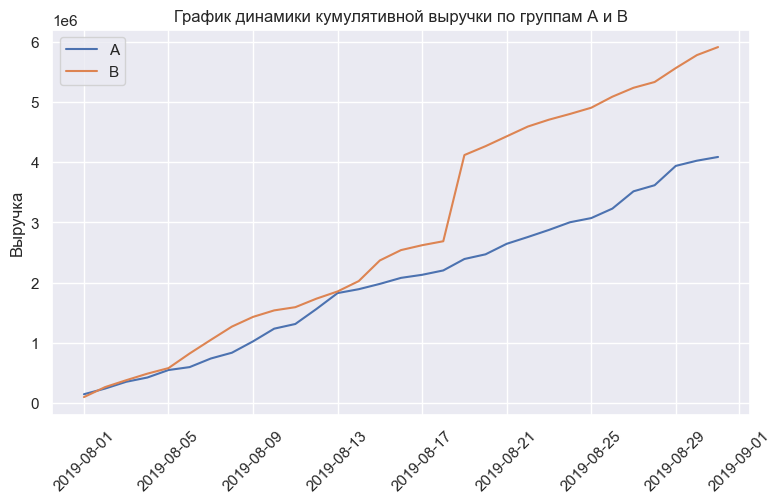

In [19]:
plt.plot(cumulative_revenue_A['date'],
         cumulative_revenue_A['revenue'],
         label='A')
plt.plot(cumulative_revenue_B['date'],
         cumulative_revenue_B['revenue'],
         label='B')

plt.title('График динамики кумулятивной выручки по группам А и В')
plt.ylabel("Выручка")
plt.xticks(rotation=45)
plt.legend()
plt.show()

Куммулятивная выручка в обеих группах линейно увеличивается на протяжении всего теста. В группе "B" есть резкий скачок 18-19 августа, который может свидетельствовать о всплеске числа заказов или о появлении неожидано дорогих заказов.

### Построение графика кумулятивного среднего чека по группам.

Построим график кумулятивного среднего чека по группам.

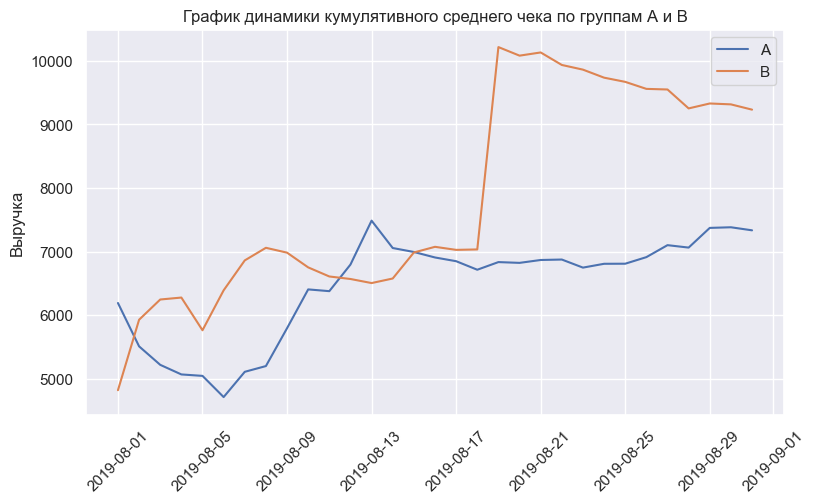

In [20]:
plt.plot(cumulative_revenue_A['date'], 
         cumulative_revenue_A['revenue']/cumulative_revenue_A['orders'], 
         label='A')

plt.plot(cumulative_revenue_B['date'], 
         cumulative_revenue_B['revenue']/cumulative_revenue_B['orders'], 
         label='B')

plt.title('График динамики кумулятивного среднего чека по группам А и В')
plt.ylabel("Выручка")
plt.xticks(rotation=45)
plt.legend()
plt.show()

Из графика можно сделать вывод, что резкий всплеск и плавное снижение в группе "В" свидетельствует о попадании в выборку крупных заказов, в то время как график группы "А" спустя две недели стабилизировался.

### Построение графика относительного изменения кумулятивного среднего чека группы B к группе A

In [21]:
# собираем данные в одном датафрейме
merged_cumulative_revenue = (cumulative_revenue_A
        .merge(cumulative_revenue_B, 
               left_on='date', 
               right_on='date', 
               how='left', 
               suffixes=['A', 'B']
              )
                            )

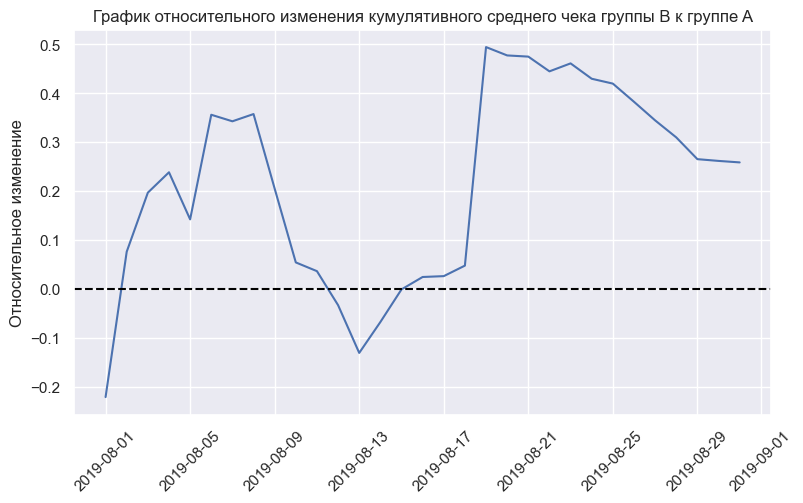

In [22]:
# cтроим отношение средних чеков
plt.plot(merged_cumulative_revenue['date'],
         (merged_cumulative_revenue['revenueB']/merged_cumulative_revenue['ordersB'])/
         (merged_cumulative_revenue['revenueA']/merged_cumulative_revenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.ylabel('Относительное изменение')
plt.xticks(rotation=45)
plt.show()

Как мы говорили ранее, 18-19 августа были крупные заказы.

### Построение графика кумулятивного среднего количества заказов на посетителя по группам.

In [23]:
# считаем кумулятивное среднее количество заказов на посетителя
cumulative_data['conversion'] = cumulative_data['orders']/cumulative_data['visitors']

In [24]:
# отделяем данные по группе A и В
cumulative_data_A = cumulative_data[cumulative_data['group']=='A']
cumulative_data_B = cumulative_data[cumulative_data['group']=='B']

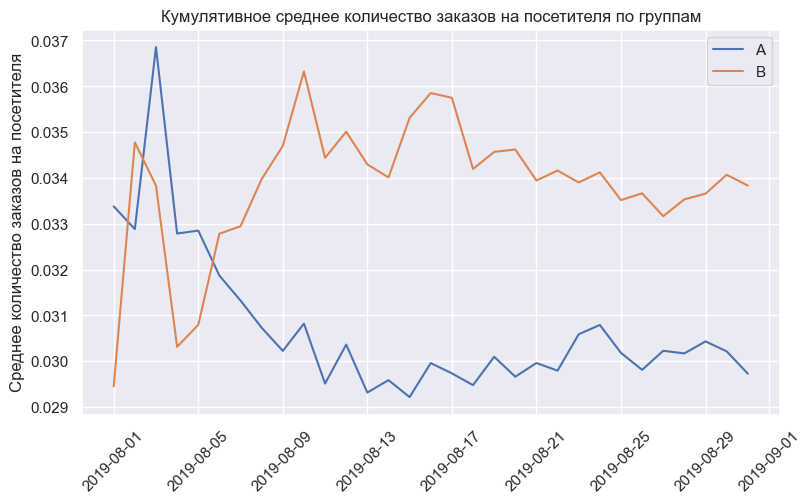

In [25]:
# строим графики
plt.plot(cumulative_data_A['date'], cumulative_data_A['conversion'], label='A')
plt.plot(cumulative_data_B['date'], cumulative_data_B['conversion'], label='B')
plt.legend()
plt.title('Кумулятивное среднее количество заказов на посетителя по группам')
plt.ylabel('Среднее количество заказов на посетителя')
plt.xticks(rotation=45)
plt.show()

Из графиков видим, что **кумулятивное среднее количество заказов** группы "А" после 5 августа пошла на спад, а группа "В" сильно вырвалась вперед.\
Оба графика со временем стабилизировались.

### Построение графика относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A.

In [26]:
# собираем данные в одном датафрейме
merged_cumulative_conversions = (cumulative_data_A[['date','conversion']]
        .merge(cumulative_data_B[['date','conversion']], 
               left_on='date', 
               right_on='date', 
               how='left', 
               suffixes=['A', 'B']
              )
                                )

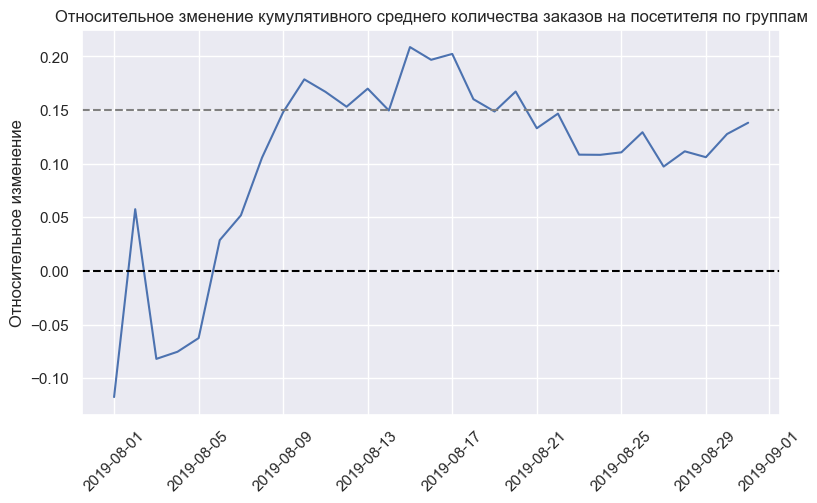

In [27]:
plt.plot(merged_cumulative_conversions['date'], 
         merged_cumulative_conversions['conversionB']/
         merged_cumulative_conversions['conversionA']-1
        )

plt.axhline(y=0.0, color='black', linestyle='--')
plt.axhline(y=0.15, color='grey', linestyle='--')
plt.title('Относительное зменение кумулятивного среднего количества заказов на посетителя по группам')
plt.ylabel('Относительное изменение')
plt.xticks(rotation=45)
plt.show()

Видим что относительный прирост сначала был отрицательным, но после 5 августа пошел сильный рост. С 9 августа стабилизировался.

### Построение точечного графика количества заказов по пользователям.

In [28]:
# подсчитаем количесво заказов по пользователям
orders_by_users = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)
orders_by_users.sort_values(by='transaction_id', ascending=False).head(10)

,visitor_id,transaction_id
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5
744,3062433592,5
55,237748145,5
917,3803269165,5
299,1230306981,5
897,3717692402,5


In [29]:
orders_by_users.columns = ['visitor_id', 'orders']
aa = orders_by_users.groupby('orders').agg({'visitor_id' : 'count'})
aa

,visitor_id
orders,
1,937
2,64
3,17
4,3
5,6
8,1
9,1
11,2


Построим гистрограмму распределения количества заказов на одного пользователя.

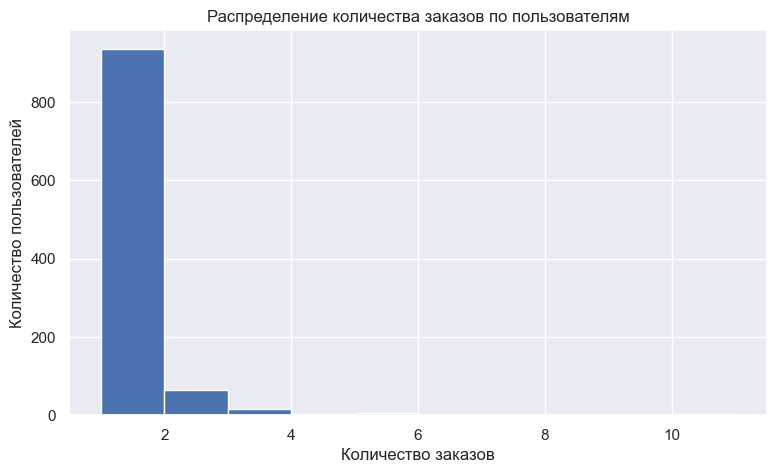

In [30]:
plt.hist(orders_by_users['orders'])
plt.title('Распределение количества заказов по пользователям')
plt.xlabel('Количество заказов')
plt.ylabel('Количество пользователей')
plt.show()

Построим точечную диаграмму распределения количества заказов на одного пользователя

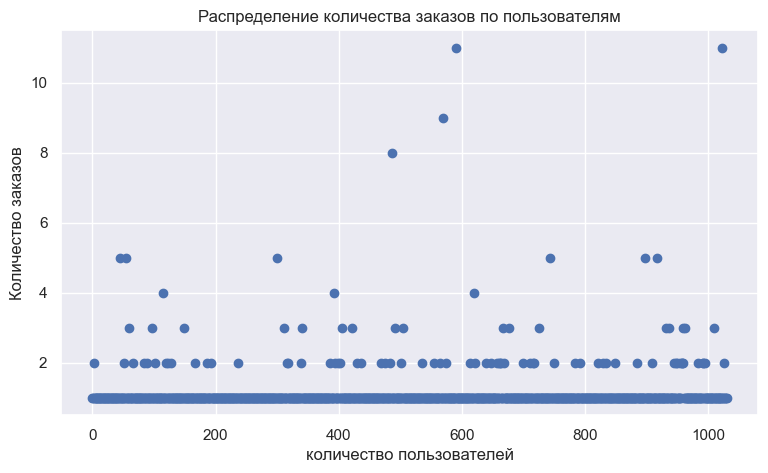

In [31]:
x_values = pd.Series(range(0,len(orders_by_users)))

plt.scatter(x_values, orders_by_users['orders'])
plt.title('Распределение количества заказов по пользователям')
plt.ylabel('Количество заказов')
plt.xlabel('количество пользователей')
plt.show()

Видим, что есть пользователи, оформившие 5, 8, 9 и 11 заказов. Значительно больше, чем обычный пользователь. Большинство пользователей оформляли заказ 1 раз. Также видим достаточное количество пользователей с 2 и 3 заказами.

### Подсчет 95-й и 99-й перцентили количества заказов на пользователя. Выбор границы для определения аномальных пользователей.

In [32]:
np.percentile(orders_by_users['orders'], [95, 99])

array([2., 4.])

Не более 5% пользователей совершили больше чем 2 заказа. И 1% пользователей заказывали более 4 раз.\
Примем верхнюю границу в 4 заказа.

### Построение точечного графика стоимостей заказов.

Изучим гистограмму распределения стоимостей заказов

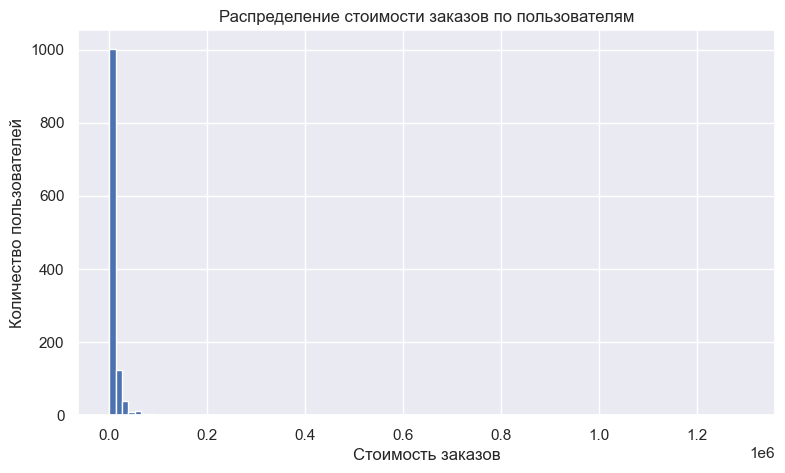

In [33]:
plt.hist(orders['revenue'], bins=100) 
plt.title('Распределение стоимости заказов по пользователям')
plt.xlabel('Стоимость заказов')
plt.ylabel('Количество пользователей')
plt.show()

Построим точечную диаграмму распределения стоимостей заказов

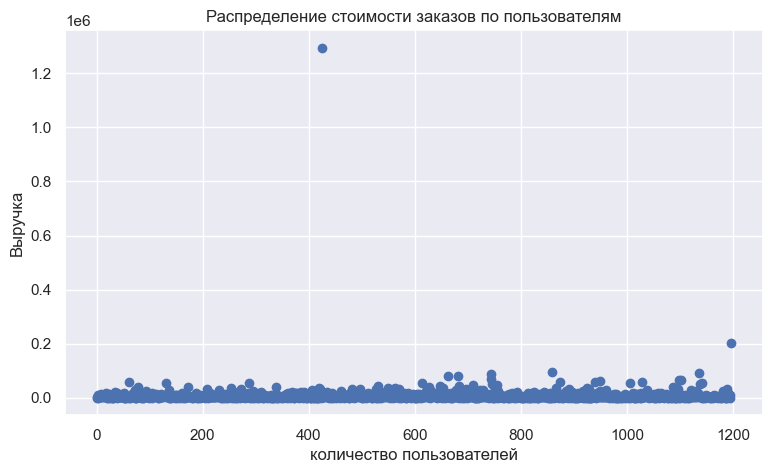

In [34]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.title('Распределение стоимости заказов по пользователям')
plt.xlabel('количество пользователей')
plt.ylabel('Выручка')
plt.show()

Видим сильные выбросы. Поправим график для наглядности.

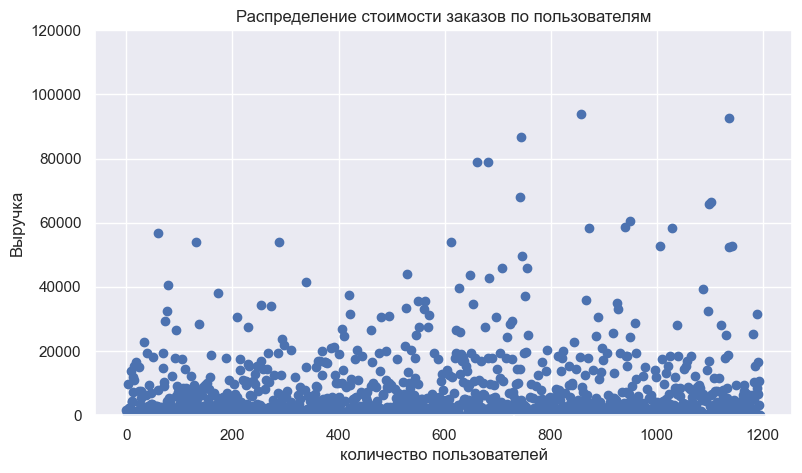

In [35]:
plt.ylim(0, 120000)
plt.scatter(x_values, orders['revenue'])
plt.title('Распределение стоимости заказов по пользователям')
plt.xlabel('количество пользователей')
plt.ylabel('Выручка')
plt.show()

Из графиков видим, что основная масса заказов не превышает 15 000 рублей, но в выборке также присутсвуют выбросы. Чтобы понять, на какой границе их отсеивать, посчитаем перцентили.

### Подсчет 95-й и 99-й перцентили стоимости заказов. Выбор границы для определения аномальных заказов.

In [36]:
np.percentile(orders['revenue'], [95, 99])

array([28000. , 58233.2])

Не более 5% заказов превышают стоимоть в 28 000 рублей, 1% превышают 58 233,2 рубля.
Примем границу в 58 233.

**Вывод:** Разумно выбрать 4 заказа на одного пользователя за верхнюю границу числа заказов и 58 233 рубля как верхнюю границу стоимости заказа, и отсеять аномальных пользователей по ней.

## Статистический анализ

### Подсчет статистической значимости различий в среднем количестве заказов на посетителя между группами по «сырым» данным.

Посчитаем статистическую значимость различий в среднем числе заказов на пользователя и среднем чеке между группами по «сырым» данным — без удаления аномальных пользователей.

In [37]:
# Сформулируем гипотезы.
H0 = 'Статистически значимых различий в среднем количестве заказов между группами по "сырым" данным нет.'
H1 = 'Статистически значимые различия в среднем количестве заказов между группами по "сырым" данным есть.'
alpha = 0.05

Начнём с подготовки данных.

In [38]:
visitors_daily_a = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitors_daily_a.columns = ['date', 'visitors_per_date_a']

visitors_cummulative_a = visitors_daily_a.apply(
    lambda x: visitors_daily_a[visitors_daily_a['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_a': 'sum'}
    ),
    axis=1,
)
visitors_cummulative_a.columns = ['date', 'visitors_cummulative_a']

visitors_daily_b = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitors_daily_b.columns = ['date', 'visitors_per_date_b']

visitors_cummulative_b = visitors_daily_b.apply(
    lambda x: visitors_daily_b[visitors_daily_b['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_b': 'sum'}
    ),
    axis=1,
)
visitors_cummulative_b.columns = ['date', 'visitors_cummulative_b']

orders_daily_a = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_daily_a.columns = ['date', 'orders_daily_a', 'revenue_per_date_a']

orders_cummulative_a = orders_daily_a.apply(
    lambda x: orders_daily_a[orders_daily_a['date'] <= x['date']].agg(
        {'date': 'max', 'orders_daily_a': 'sum', 'revenue_per_date_a': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])

orders_cummulative_a.columns = ['date','orders_cummulative_a','revenue_cummulative_a']

orders_daily_b = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_daily_b.columns = ['date', 'orders_daily_b', 'revenue_per_date_b']

orders_cummulative_b = orders_daily_b.apply(
    lambda x: orders_daily_b[orders_daily_b['date'] <= x['date']].agg(
        {'date': 'max', 'orders_daily_b': 'sum', 'revenue_per_date_b': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])

orders_cummulative_b.columns = ['date','orders_cummulative_b','revenue_cummulative_b']


data = (
    orders_daily_a.merge(
        orders_daily_b, left_on='date', right_on='date', how='left'
    )
    .merge(orders_cummulative_a, left_on='date', right_on='date', how='left')
    .merge(orders_cummulative_b, left_on='date', right_on='date', how='left')
    .merge(visitors_daily_a, left_on='date', right_on='date', how='left')
    .merge(visitors_daily_b, left_on='date', right_on='date', how='left')
    .merge(visitors_cummulative_a, left_on='date', right_on='date', how='left')
    .merge(visitors_cummulative_b, left_on='date', right_on='date', how='left')
)

data.head(10)

,date,orders_daily_a,revenue_per_date_a,orders_daily_b,revenue_per_date_b,orders_cummulative_a,revenue_cummulative_a,orders_cummulative_b,revenue_cummulative_b,visitors_per_date_a,visitors_per_date_b,visitors_cummulative_a,visitors_cummulative_b
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280
5,2019-08-06,18,48484,28,242342,127,598401,129,824337,667,655,3985,3935
6,2019-08-07,18,142417,24,225334,145,740818,153,1049671,644,709,4629,4644
7,2019-08-08,16,96279,27,220918,161,837097,180,1270589,610,654,5239,5298
8,2019-08-09,16,188506,25,160812,177,1025603,205,1431401,617,610,5856,5908
9,2019-08-10,16,210495,23,107802,193,1236098,228,1539203,406,369,6262,6277


Названия столбцов данных:

 - `date` — дата;
 - `orders_daily_a` — количество заказов в выбранную дату в группе A;
 - `revenue_per_date_a` — суммарная выручка в выбранную дату в группе A;
 - `orders_daily_b` — количество заказов в выбранную дату в группе B;
 - `revenue_per_date_b` — суммарная выручка в выбранную дату в группе B;
 - `orders_cummulative_a` — суммарное число заказов до выбранной даты включительно в группе A;
 - `revenue_cummulative_a` — суммарная выручка до выбранной даты включительно в группе A;
 - `orders_cummulative_b` — суммарное количество заказов до выбранной даты включительно в группе B;
 - `revenue_cummulative_b` — суммарная выручка до выбранной даты включительно в группе B;
 - `visitors_per_date_a` — количество пользователей в выбранную дату в группе A;
 - `visitors_per_date_b` — количество пользователей в выбранную дату в группе B;
 - `visitors_cummulative_a` — количество пользователей до выбранной даты включительно в группе A;
 - `visitors_cummulative_b` — количество пользователей до выбранной даты включительно в группе B.

Создадим переменные `orders_by_users_A` и `orders_by_users_B` со столбцами `'visitor_id'`, `'orders'`. В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов. 

In [39]:
orders_by_users_A = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_A.columns = ['visitor_id', 'orders']

orders_by_users_B = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_B.columns = ['visitor_id', 'orders']

Объявим переменные `sample_A` и `sample_B`, в которых пользователям из разных групп будет соответствовать количество заказов.

In [40]:
sample_A = pd.concat([orders_by_users_A['orders'],
                      pd.Series(0, index=np.arange(data['visitors_per_date_a'].sum() - len(orders_by_users_A['orders'])),
                                name='orders')],axis=0)

sample_B = pd.concat([orders_by_users_B['orders'],
                      pd.Series(0, index=np.arange(data['visitors_per_date_b'].sum() - len(orders_by_users_B['orders'])),
                                name='orders')],axis=0) 

Применим статистический критерий Манна-Уитни к полученным выборкам.

In [41]:
p_value = stats.mannwhitneyu(sample_A, sample_B)[1]

print("P-value: {0:.3f}".format(p_value))

if (p_value < alpha):
        print('Отвергаем нулевую гипотезу:', H1)
else:
        print('Не получилось отвергнуть нулевую гипотезу:', H0)

print("Относительный прирост группы В к группе А: {0:.3%}".format(sample_B.mean() / sample_A.mean() - 1))

P-value: 0.017
Отвергаем нулевую гипотезу: Статистически значимые различия в среднем количестве заказов между группами по "сырым" данным есть.
Относительный прирост группы В к группе А: 13.808%


По «сырым» данным различия в среднем числе заказов между группами A и B есть, `p_value` < 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов между группами нет, следует отвергнуть.\
Относительный проигрыш группы А равен 13.8%.

### Подсчет статистической значимости различий в среднем чеке заказа между группами по «сырым» данным.

Проверим статистическую значимость различий в среднем чеке между сегментами.

In [42]:
# Сформулируем гипотезы.
H0 = 'Статистически значимых различий в среднем чеке между группами по "сырым" данным нет.'
H1 = 'Статистически значимые различия в среднем чеке между группами по "сырым" данным есть.'
alpha = 0.05

Применим статистический критерий Манна-Уитни к полученным выборкам.

In [43]:
p_value = stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]

print('P-value: {0:.3f}'.format(p_value))

if (p_value < alpha):
        print('Отвергаем нулевую гипотезу:', H1)
else:
        print('Не получилось отвергнуть нулевую гипотезу:', H0)

print('Относительный прирост группы В к группе А: {0:.3%}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

P-value: 0.729
Не получилось отвергнуть нулевую гипотезу: Статистически значимых различий в среднем чеке между группами по "сырым" данным нет.
Относительный прирост группы В к группе А: 25.871%


Так как тест показал, что гипотезу мы не отвергаем, то можно утверждать, что разница в 25.87% между группами В и А не является статистически значимым результатом.

### Подсчет статистической значимости различий в среднем количестве заказов на посетителя между группами по «очищенным» данным.

Узнаем, сколько всего аномальных пользователей.

In [44]:
# cделаем срезы пользователей с числом заказов больше 4
users_with_many_orders = pd.concat(
    [
        orders_by_users_A[orders_by_users_A['orders'] > 4]['visitor_id'],
        orders_by_users_B[orders_by_users_B['orders'] > 4]['visitor_id'],
    ],
    axis=0,
)
# cделаем срезы пользователей совершивших заказы дороже 58 233
users_with_expensive_orders = orders[orders['revenue'] > 58233]['visitor_id']
# объединим их в таблицу
abnormal_users = (
    pd.concat([users_with_many_orders, users_with_expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormal_users.head(5))
print()
print('Всего', abnormal_users.shape[0], 'аномальных пользователей') 

1099     148427295
949      887908475
744      888512513
1103    1164614297
1136    1307669133
Name: visitor_id, dtype: int64

Всего 15 аномальных пользователей


In [45]:
many_orders = np.percentile(orders_by_users['orders'], 99)
expensive_orders = np.percentile(orders['revenue'], 99)

# cделаем срезы пользователей с числом заказов больше 4
users_with_many_orders = pd.concat(
    [
        orders_by_users_A[orders_by_users_A['orders'] > many_orders]['visitor_id'],
        orders_by_users_B[orders_by_users_B['orders'] > many_orders]['visitor_id'],
    ],
    axis=0,
)
# cделаем срезы пользователей совершивших заказы дороже 58 233
users_with_expensive_orders = orders[orders['revenue'] > expensive_orders]['visitor_id']
# объединим их в таблицу
abnormal_users = (
    pd.concat([users_with_many_orders, users_with_expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormal_users.head(5))
print()
print('Всего', abnormal_users.shape[0], 'аномальных пользователей') 

1099     148427295
949      887908475
744      888512513
1103    1164614297
1136    1307669133
Name: visitor_id, dtype: int64

Всего 15 аномальных пользователей


Посчитаем статистическую значимость различий в среднем количестве заказов между группами теста по очищенным данным. Сначала подготовим выборки количества заказов по пользователям по группам теста.

In [46]:
sample_A_filtered = pd.concat(
    [
        orders_by_users_A[
            np.logical_not(orders_by_users_A['visitor_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_a'].sum() - len(orders_by_users_A['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sample_B_filtered = pd.concat(
    [
        orders_by_users_B[
            np.logical_not(orders_by_users_B['visitor_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_b'].sum() - len(orders_by_users_B['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 

In [47]:
# Сформулируем гипотезы.
H0 = 'Статистически значимых различий в среднем количестве заказов между группами по "очищенным" данным нет.'
H1 = 'Статистически значимые различия в среднем количестве заказов между группами по "очищенным" данным есть.'
alpha = 0.05

Применим статистический критерий Манна-Уитни к полученным выборкам.

In [48]:
p_value = stats.mannwhitneyu(sample_A_filtered, sample_B_filtered)[1]
print('P-value: {0:.3f}'.format(p_value))

if (p_value < alpha):
        print('Отвергаем нулевую гипотезу:', H1)
else:
        print('Не получилось отвергнуть нулевую гипотезу:', H0)

print('Относительный прирост группы В к группе А: {0:.3%}'.format(sample_B_filtered.mean()/sample_A_filtered.mean()-1)) 

P-value: 0.014
Отвергаем нулевую гипотезу: Статистически значимые различия в среднем количестве заказов между группами по "очищенным" данным есть.
Относительный прирост группы В к группе А: 15.331%


На «очищенных» данных результаты по среднему количеству заказов практически не изменились. Относительный прирост группы В к группе А вырос до 15,33%.

### Подсчет статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным.

In [49]:
# Сформулируем гипотезы.
H0 = 'Статистически значимых различий в среднем чеке между группами по "очищенным" данным нет.'
H1 = 'Статистически значимые различия в среднем чеке между группами по "очищенным" данным есть.'
alpha = 0.05

Подсчитаем статистическую значимость различий в среднем чеке после удаления аномальных пользователей

In [50]:
p_value = stats.mannwhitneyu(orders[np.logical_and(orders['group'] == 'A',
                                                   np.logical_not(orders['visitor_id'].isin(abnormal_users)))]['revenue'],
                             orders[np.logical_and(orders['group'] == 'B',
                                                   np.logical_not(orders['visitor_id'].isin(abnormal_users)))]['revenue'])[1]
print('P-value: {0:.3f}'.format(p_value))

if (p_value < alpha):
        print('Отвергаем нулевую гипотезу:', H1)
else:
        print('Не получилось отвергнуть нулевую гипотезу:', H0)

print('Относительный прирост группы В к группе А: {0:.3%}'
      .format(orders[np.logical_and(orders['group'] == 'B',
                                   np.logical_not(orders['visitor_id'].isin(abnormal_users)))]['revenue'].mean()/
             orders[np.logical_and(orders['group'] == 'A',
                                   np.logical_not(orders['visitor_id'].isin(abnormal_users)))]['revenue'].mean()- 1)) 

P-value: 0.851
Не получилось отвергнуть нулевую гипотезу: Статистически значимых различий в среднем чеке между группами по "очищенным" данным нет.
Относительный прирост группы В к группе А: -0.575%


На «очищенных» данных P-value вырос, различий в среднем чеке нет. Без выбросов группа А наоборот показала очень незначительный прирост на 0,58%.

## Общий вывод

**В данной работе мы достигли поставленных задач:**

**1. *Подготовили данные к анализу, исправили названия и форматы столбцов.***


**2. *Часть приоритизации гипотез.***

Изучили гипотезы, предоставленных отделом Маркетинга, провели их ранжирование с применением методов `ICE` и `RICE`.

Согласно методу `ICE`, в первую очередь необходимо обратить внимание на гипотезы:

- "Запустить акцию, дающую скидку на товар в день рождения";
- "Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей";
- "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок".

Если ранжирование гипотез должно включать в себя и охват пользователей интернет-магазина (метод `RICE`), то места необходимо распределить таким образом:

- "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок";
- "Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа";
- "Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей".

Как видно, в обоих методах в топе 3 находятся гипотезы под номерами **0** и **7** "*Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей*" и "*Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок*" соответственно. На них сделать особый акцент.

**3. *Часть проведения и анализа А/В теста.***

В данной части изучили графики с кумулятивными значениями, на основании которых было обнаружено абсолютное превосходство группы В над групой А в части конверсии, выручки, среднего чека. Также заметили сильные выбросы как в стоимости заказов, так и в количесве заказов на одного пользователя.\
Подсчетом перцетилей определили верхние границы количества и стоимости заказов.

**4. *Часть статистического анализа.***

- Есть статистически значимое различие по конверсии между группами как по «сырым», так и по данным после фильтрации аномалий. Конверсия группы В выше, чем в А, на 14-15%;

- Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по «очищенным» данным;

- График различия среднего количества заказов между группами B и A показывает, что результаты группы В стабильно лучше группы А;

- График различия среднего чека говорит о том, что результаты группы B лучше группы А более чем на 20%, но ухудшаются день ото дня;

- На основании вышеизложенного тест следует остановить, зафиксировав победу группы B (ее конверсия значительно выше конверсии группы А).